# VAE testing on Fashion-MNIST

In [2]:
#@title Import libraries

import tensorflow as tf
import os
import numpy as np

#always check if you have available GPUs --> faster training
print(tf.config.list_physical_devices('GPU'))

#NB: if you do not find any GPU, check "Runtime -> Change Runtime Type" (October 26th 2023)

[]


In [3]:
from tensorflow.keras.datasets import fashion_mnist #(!)

(x_train,y_train), (x_test,y_test)=fashion_mnist.load_data() #https://keras.io/api/datasets/fashion_mnist/ --> returns Tuple of NumPy arrays

#some assertions to check everything is ok
assert x_train.shape ==(60000,28,28) #(number of elems,dims)
assert x_test.shape ==(10000,28,28) #(number of elems,dims)
assert y_train.shape ==(60000,) #(number of elems,dims)
assert y_test.shape ==(10000,) #(number of elems,dims)


4422102/4422102 [==============================] - 0s 0us/step


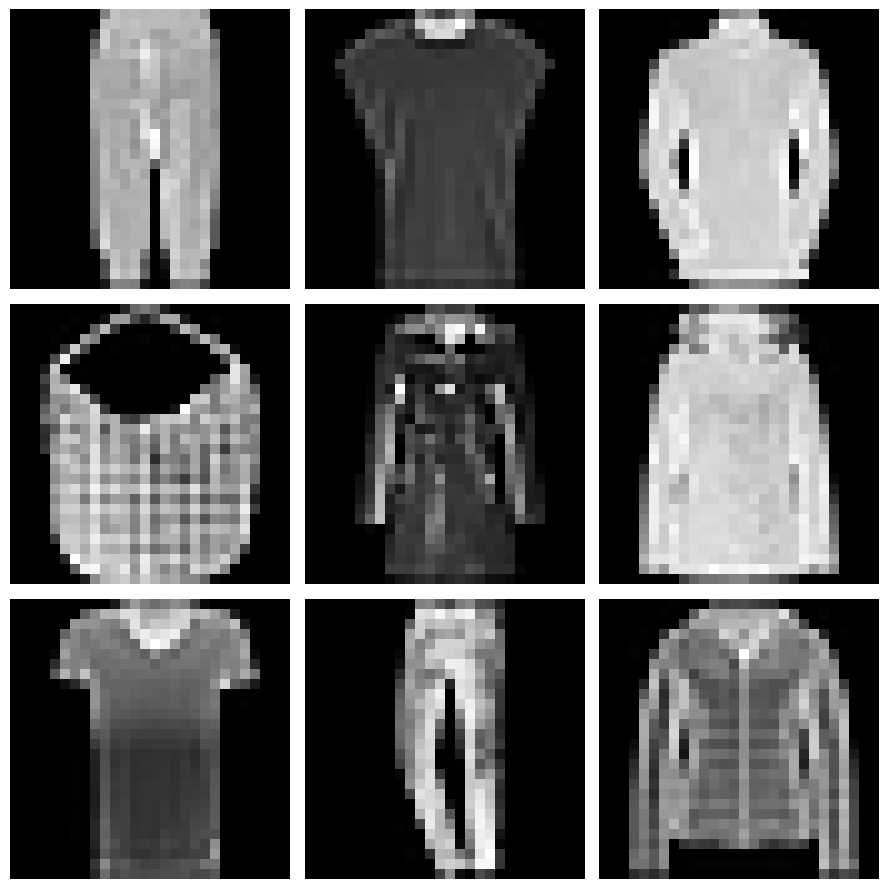

In [6]:
#Let's have a look on how dataset looks like, before starting working on it
# (it can be interpreted as a second check on the set)

import matplotlib.pyplot as plt
from random import randrange

num_elems=9 # @param {type:"integer"}
plt.figure(figsize=(num_elems,num_elems))

for i in range(num_elems):
  plt.subplot(3,3,i+1)
  choice=randrange(60000)
  plt.imshow(x_train[choice], cmap='gray')
  plt.axis('off')
  #plt.title(y_train[choice])

plt.tight_layout()
plt.show()

In [ ]:
# Since we're not interested in a classification task, we can join train and test datasets, to have more training data

complete_dataset = np.concatenate([x_train,x_test], axis=0) #TODO: vstack() function?

print(complete_dataset[0].shape) #28x28, but conv layers need 28x28xN (N== number of color channels)

# axis=-1 is like adding new axis
complete_dataset=np.expand_dims(complete_dataset,-1).astype('float32')/255 #/255 to normalize dataset (we'll have values from 0 to 1)
assert complete_dataset[0].shape==(28,28,1)

for i in range(complete_dataset[0].shape[0]):
  print(complete_dataset[0][i]) #you'll see values from 0 to 1


In [ ]:
from tensorflow import keras
from keras import layers

class SamplingLayer(layers.Layer):

  def call(self,inputs):

    #reparameterization trick --> add epsilon to the prob distribution

    mean,var=inputs
    batch=tf.shape(mean)[0]
    dim=tf.shape(mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
    return tf.exp(0.5*var)*epsilon


#Encoder-Decoder structure definition


In [ ]:
#@title Encoder (TODO: TRY DIFFERENT NETWORK?)

def Encoder(latentDim, inputs):

  #feature extractor

  l1=keras.models.Sequential([
      layers.Conv2D(128,3,activation='relu', strides=2,padding='same'),
      layers.Conv2D(64,3,activation='relu', strides=2,padding='same'),
      layers.Flatten(),
      layers.Dense(256, activation='relu') #256-size embedding vector (most relevant features)
  ])

  x=l1(inputs)

  mean=layers.Dense(latentDim)(x) #todo: add 'name' to the layer

  var=layers.Dense(latentDim)(x)

  sample=SamplingLayer()([mean,var])

  return keras.Model(inputs,[mean,var,sample],name='encoder')

inputs=keras.Input(shape=(28,28,1))
encoder=Encoder(2,inputs)

#Let's have a look at the Encoder
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 256)                  878144    ['input_5[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 2)                    514       ['sequential_4[0][0]']        
                                                                                                  
 dense_6 (Dense)             (None, 2)                    514       ['sequential_4[0][0]']        
                                                                                            

In [ ]:
#@title Decoder

def Decoder(inputs):
  l1=keras.models.Sequential([
      layers.Dense(7*7*64, activation='relu', input_shape=(inputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128,3,activation='relu',strides=2, padding='same'), #from 7*7 to 14*14
      layers.Conv2DTranspose(64,3,activation='relu',strides=2, padding='same'), #from 14*14 to 28-28
      layers.Conv2DTranspose(1,3,activation='sigmoid', padding='same') #1 output channel --> grayscale
  ])

  return keras.Model(inputs,l1(inputs),name='decoder')

inputs=keras.Input(shape=(2,))#look Encoder output shape
decoder=Decoder(inputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157633 (615.75 KB)
Trainable params: 157633 (615.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title LOSS Functions

#VAE has two loss functions, reconstruction loss and Kullback-Liebler Divergence loss function

#reconstruction_loss: penalizes images different from the input ones
def reconstruction_loss(data,reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data,reconstructed),
          axis=(1,2)
      )
  )

#KLDivergence Loss: forces to generate probability distributions similar to the original
def KLDivergence(mean,var):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5*(1+var-tf.square(mean)-tf.exp(var)),
          axis=1
      )
  )

def TotalLoss(data,reconstructed,mean,var):
  loss1=reconstruction_loss(data,reconstructed)
  loss2=KLDivergence(mean,var)
  weight=3.0 #hyperparameter
  return loss1+(loss2*weight)



In [ ]:
class VAE(keras.Model):
  def __init__(self,encoder,decoder,**kwargs):
    super(VAE,self).__init__(**kwargs)
    self.encoder=encoder
    self.decoder=decoder

  def train_step(self,data):
    with tf.GradientTape() as tape: #now we can manually define the training

      #forward path
      mean,var,z=self.encoder(data)
      decoded_img=self.decoder(z)
      total_loss=TotalLoss(data,decoded_img,mean,var)

    #backward path
    grads=tape.gradient(total_loss,self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads,self.trainable_weights))


#Training

In [ ]:
vae=VAE(encoder,decoder)

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history=vae.fit(complete_dataset,epochs=32,batch_size=128)


In [ ]:
#@title TODO: training performance???

In [ ]:
testing_dim=[1,2] #mean, var

x=vae.decoder.predict([testing_dim]).reshape((28,28))
plt.imshow(x,camp='gray')

In [ ]:
z=np.random.normal(loc=0,scale=4,size=(16,2)) #sample 16 random points from a normal distribution with mean 0 and var 4

x=vae.decoder.predict(z)

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(x[i].reshape((28,28)),cmap='gray')
  plt.axis('off')

plt.show()

In [ ]:
#@title Conditional Variational AutoEncoder (TESTING)

index=1280  # @param {type:"integer"}
elem=x_train[index]

print(elem.shape)
batch=np.expand_dims(x_train[index], axis=0)
print(batch.shape)

batch=np.expand_dims(batch,axis=-1).astype('float32')/255
print(batch.shape)

mean,var,z=vae.encoder.predict(batch)

print(z)
print(z.shape)

artificial=vae.decoder.predict([z])

plt.figure(figsize=(28,28))

plt.subplot(1,2,1)
plt.imshow(elem,cmap='gray')
plt.set_title('original')

plt.subplot(1,2,2)
plt.imshow(artificial,cmap='gray')
plt.set_title('artificial')

plt.show()

#TODO: decoded imgs Scatter plot (we could see labels distribution)